# HD 155358
This notebook is a messaround version where I'm fitting e and w instead of h and k

In [1]:
import pandas as pd
import numpy as np
import rebound
import emcee
import multiprocessing

import corner
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("RV.txt", delimiter=' ')

In [102]:
#Don't want to move to COM, want to see relative to the background. 
def fit_RV(times,theta):
    m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    
    v = np.empty(0)    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.usleep = -1
    sim.add(m=0.92)                      #add the star
    sim.dt = 2*np.pi* a1**(1.5) / 50.    #dt = 50 steps per orb per of inner planet
    sim.add(m=m1sini*mJ/sini,a=a1,M=M1,e=e1,omega=w1) 
    sim.add(m=m2sini*mJ/sini,a=a2,M=M2,e=e2,omega=w2)  
    sim.move_to_com()
    #orbit1 = sim.particles[1].calculate_orbit(sim.particles[0])
    #orbit2 = sim.particles[2].calculate_orbit(sim.particles[0])
    #print orbit1.e*np.sin(orbit1.pomega), orbit1.e*np.cos(orbit1.pomega), orbit2.e*np.sin(orbit2.pomega), orbit2.e*np.cos(orbit2.pomega), orbit1.pomega, orbit2.pomega
    for t in times*dtoyr2pi:
        sim.integrate(t)
        v = np.append(v,-AUyr2ms*sim.particles[0].vy*sini)
        #v = np.append(v,AUyr2ms*(sim.particles[0].vx*np.sin(phi) + sim.particles[0].vy*np.cos(phi))*sini) #coordinate transf from (x,y,z)->(x',y',z'), take y' component
    return v 

## Chicken Scratch

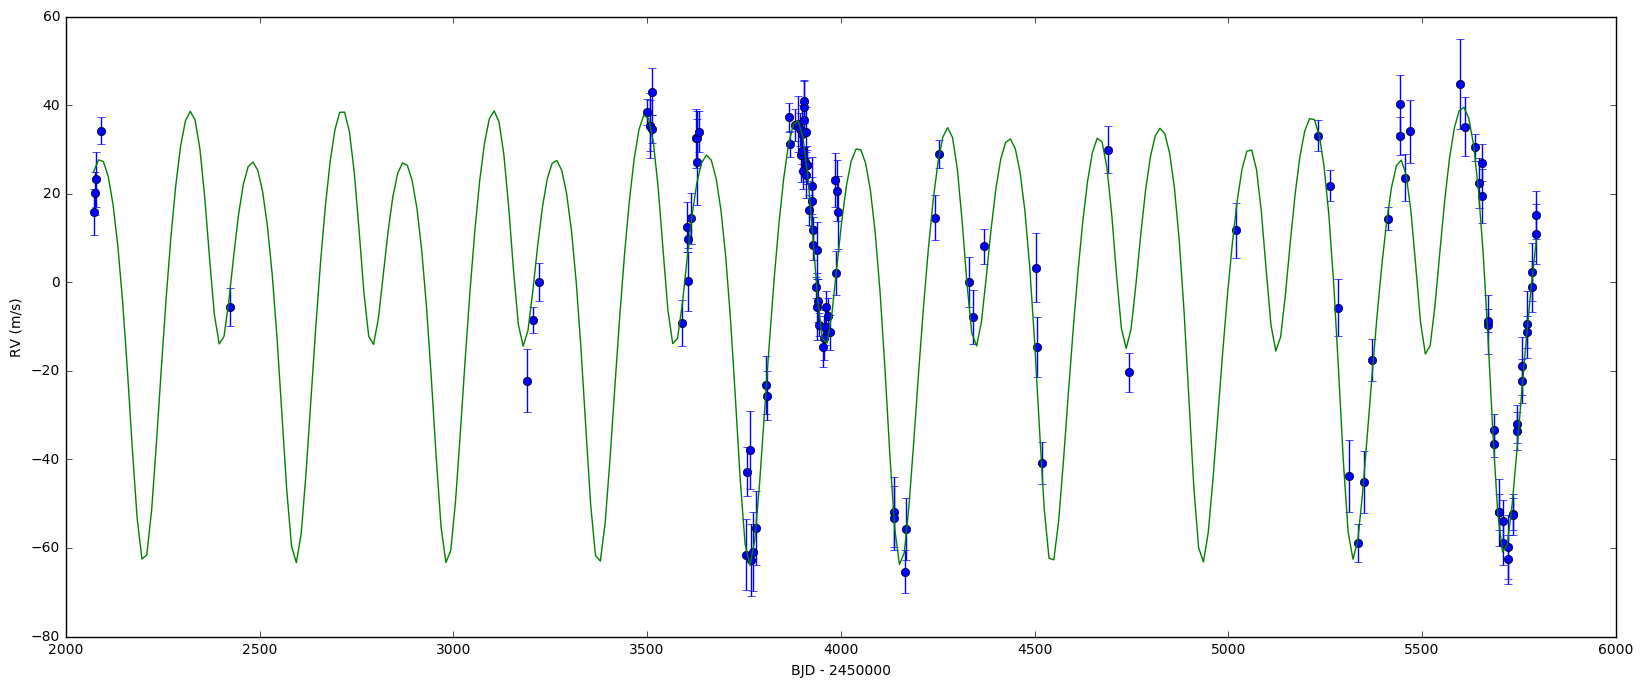

In [106]:
tt = np.linspace(t0,max(data["BJD"]),300)
times = tt - t0

#fit - m1sini,m2sini(Mjup), a1,a2(AU), e1,e2, w1,w2 (rad), M1,M2 (rad), sini (0-1)
theta_emcee = [0.923,0.818,0.642,1.018,0.156,0.032,2.88,5.85,2.10,1.46,0.615]
theta_emcee2 = [0.9163,0.851,0.643,1.017,0.142,1.58e-6,2.86,1.30,2.310,6.176,0.984]
theta_robertson = [0.85,0.82,0.64,1.02,0.17,0.16,2.5,np.pi,2.25,4.07,1]
theta = theta_emcee2

plt.figure(figsize=(20,8))
plt.errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o')
plt.plot(tt,fit_RV(times,theta))
plt.xlabel("BJD - 2450000")
plt.ylabel("RV (m/s)")

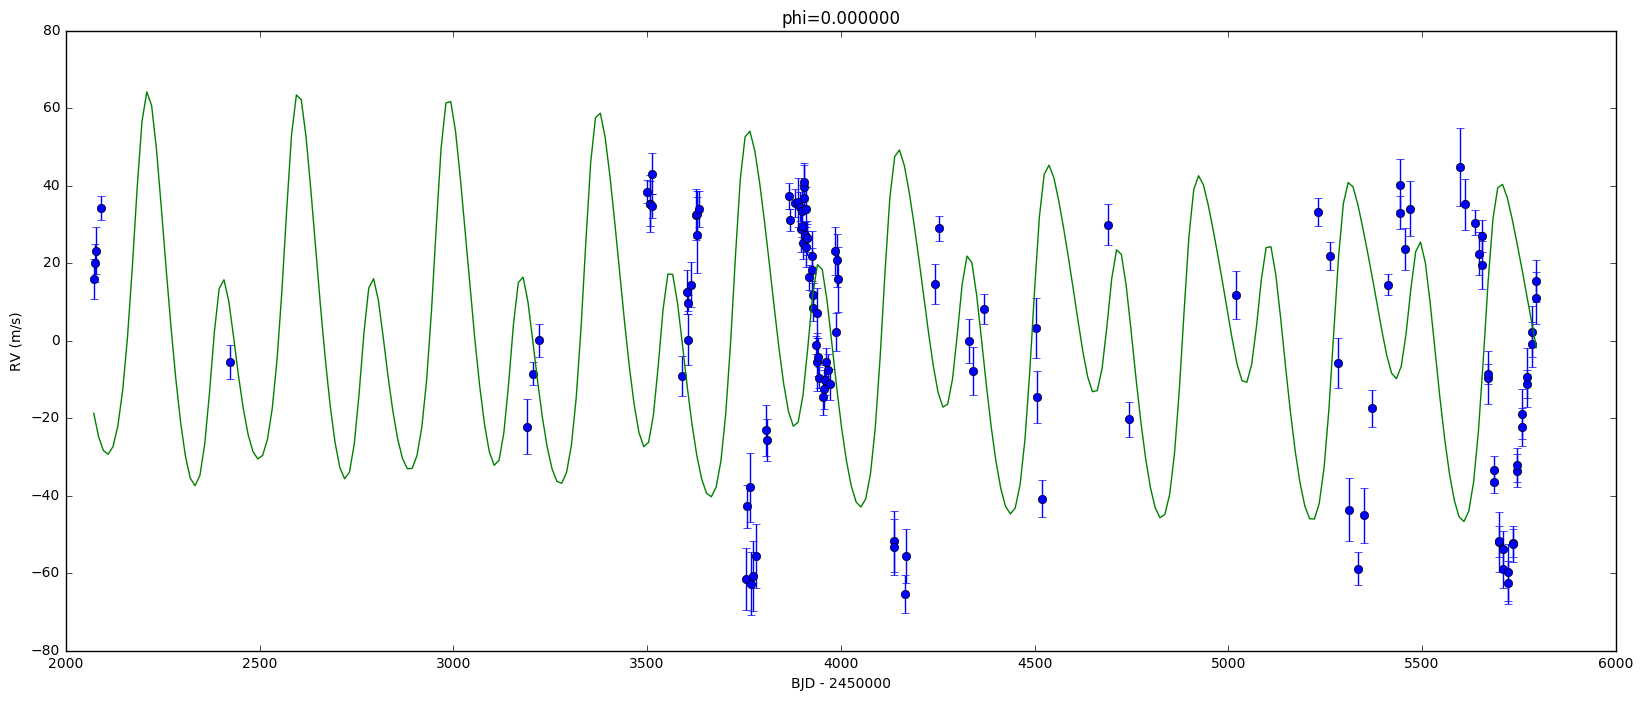

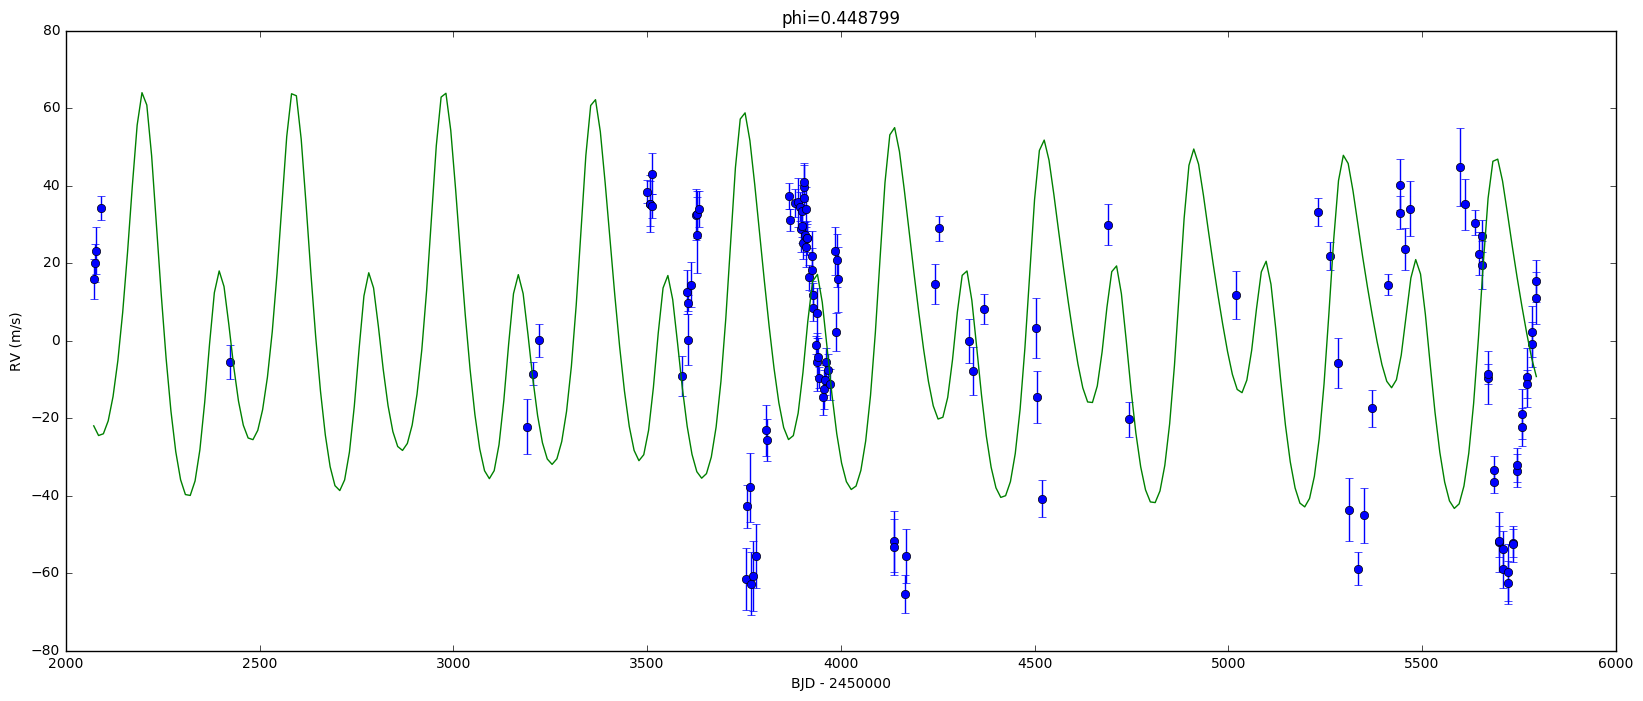

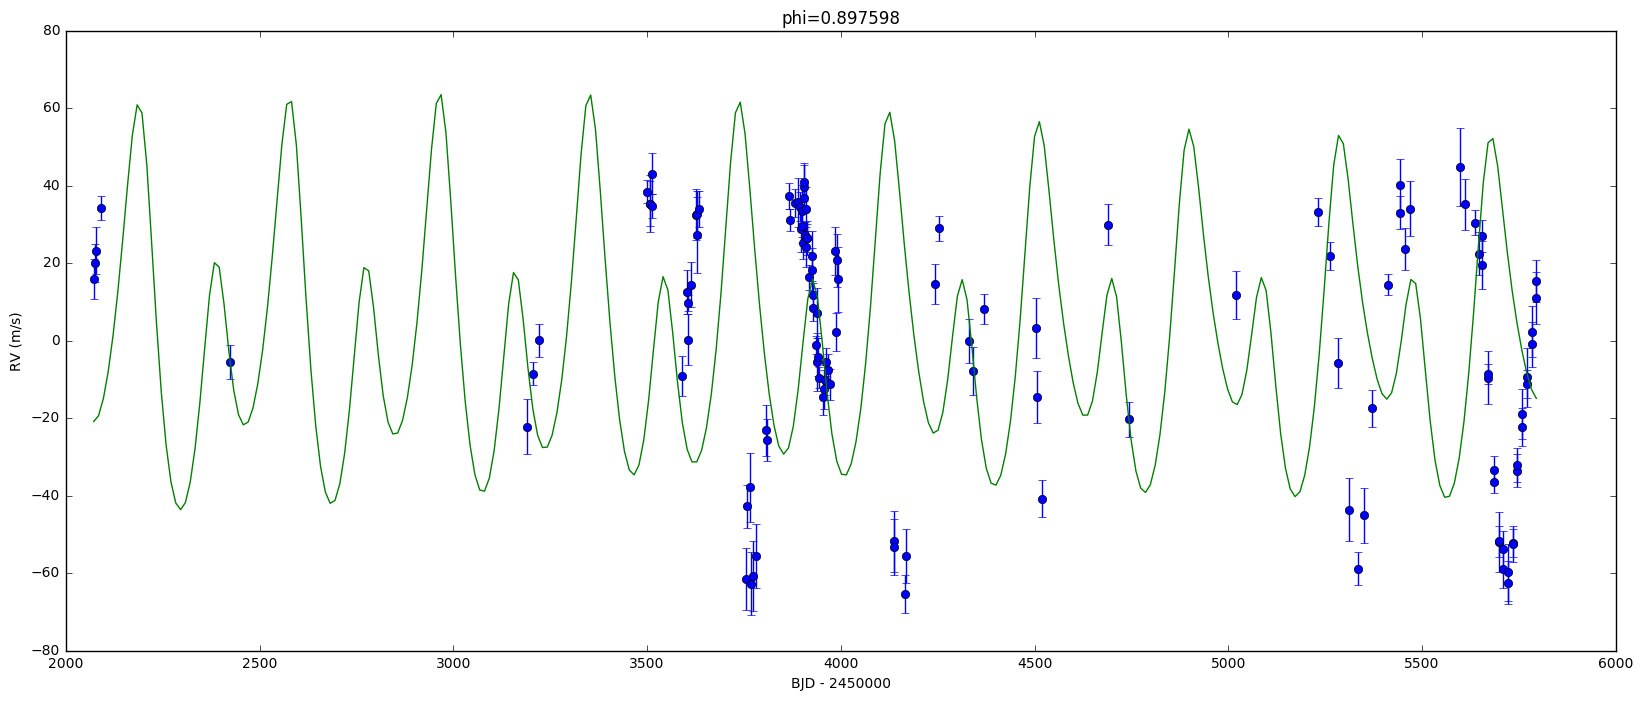

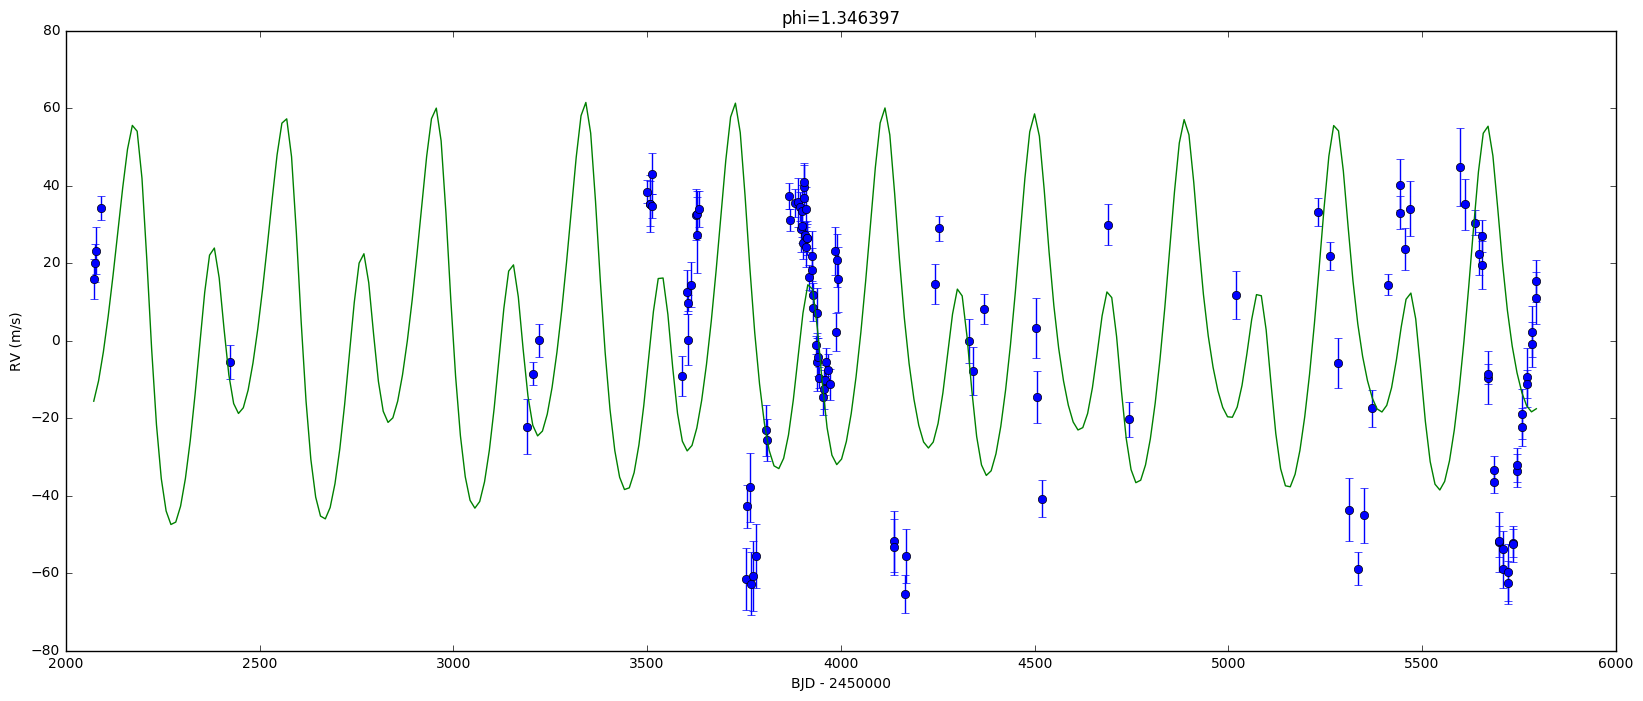

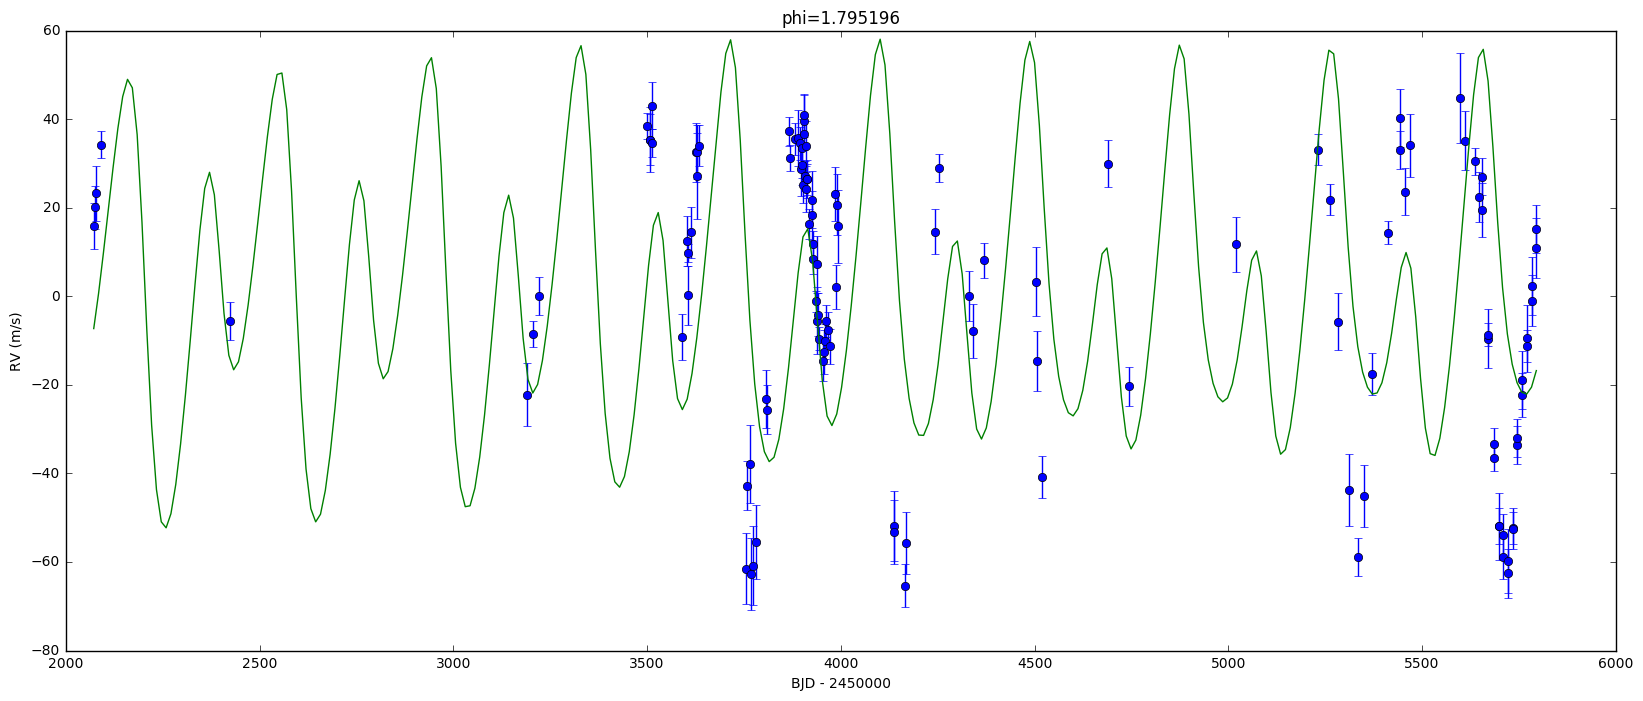

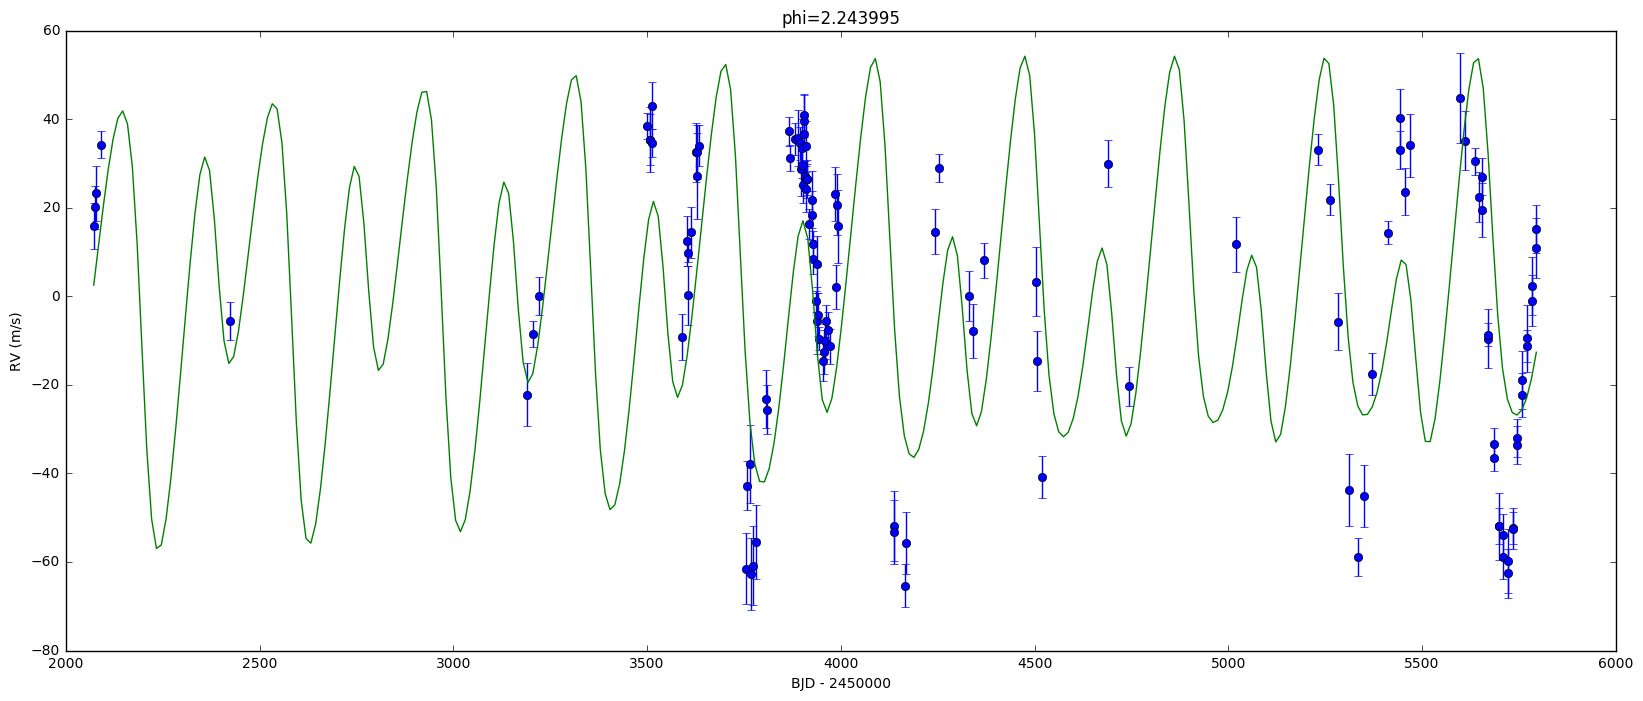

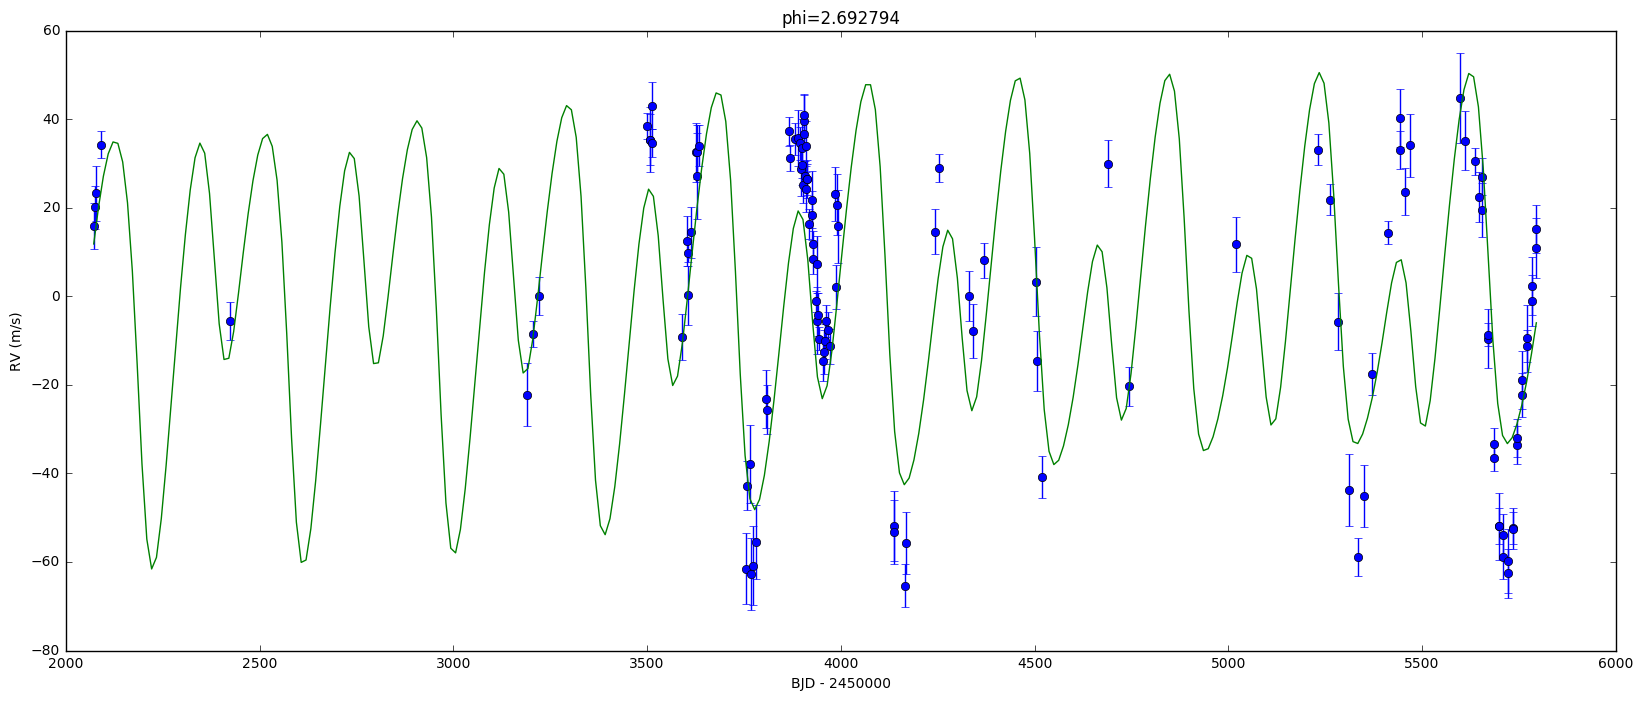

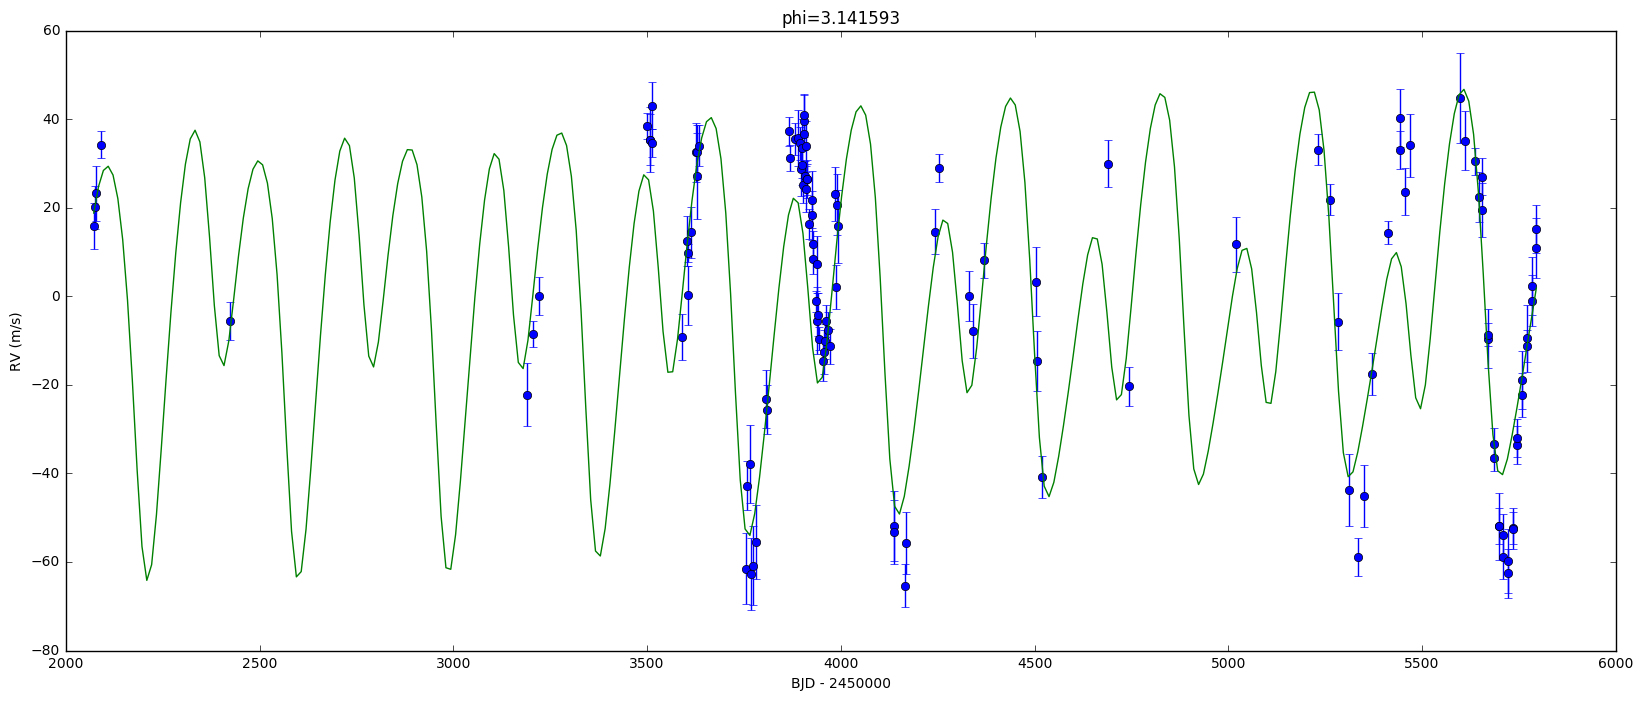

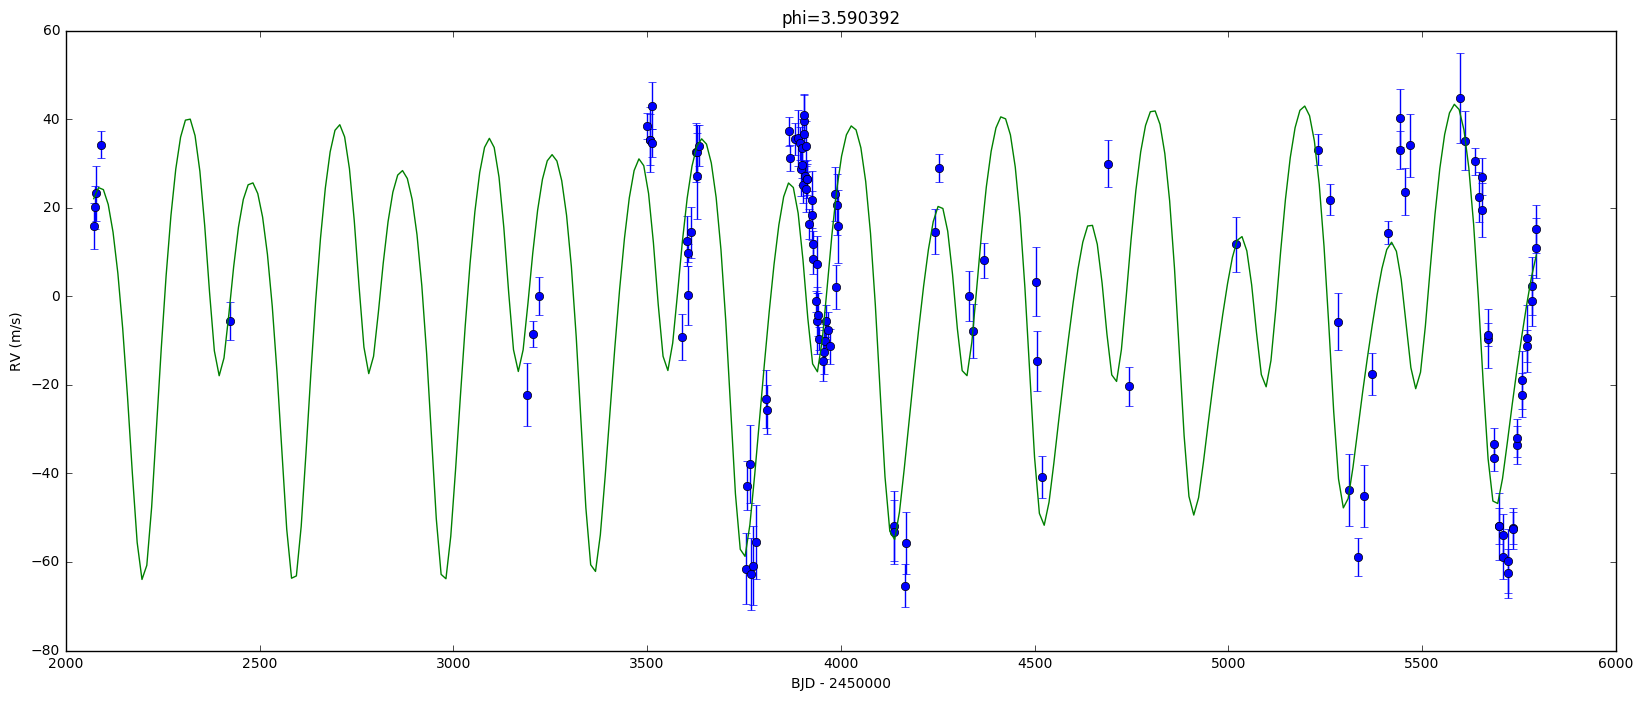

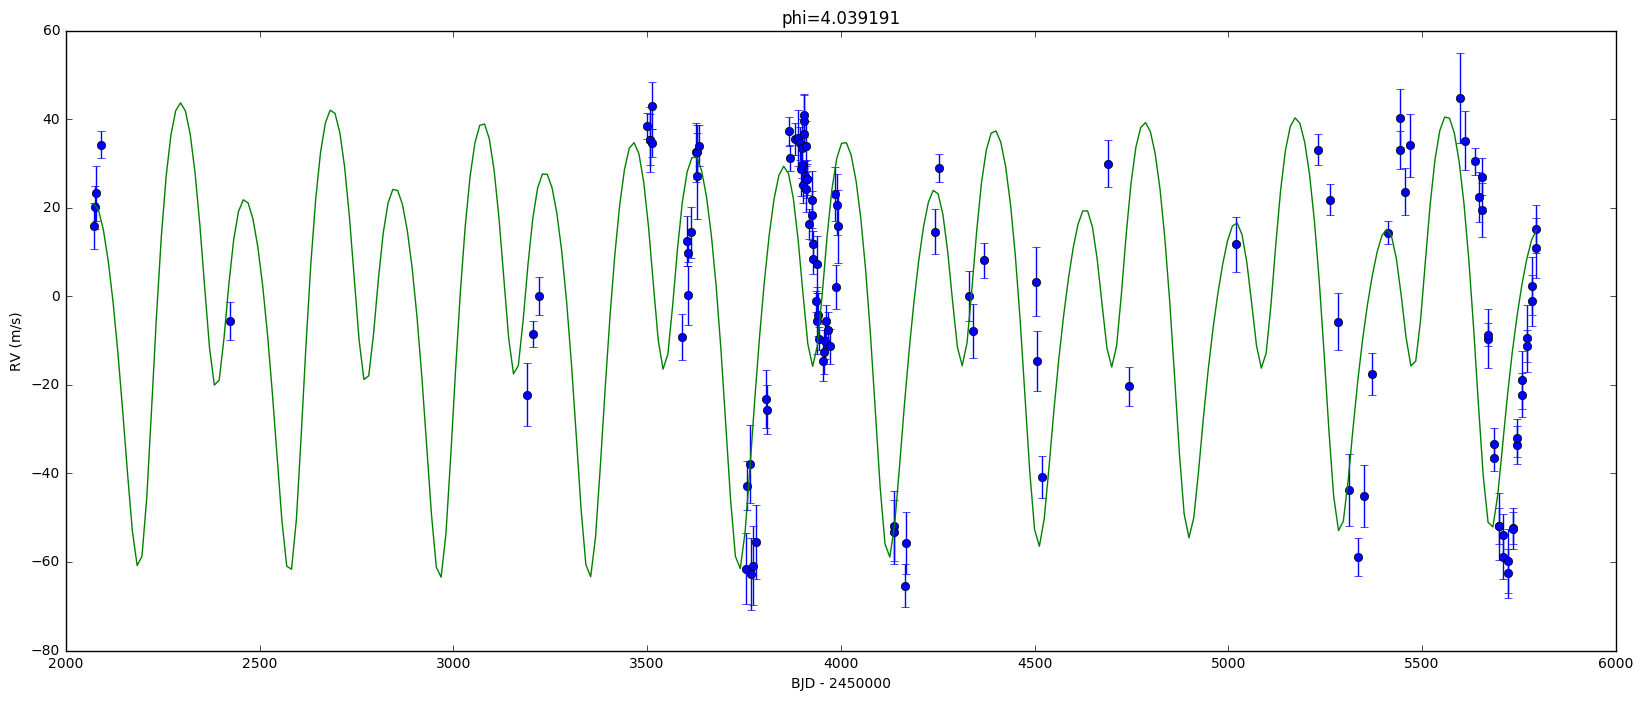

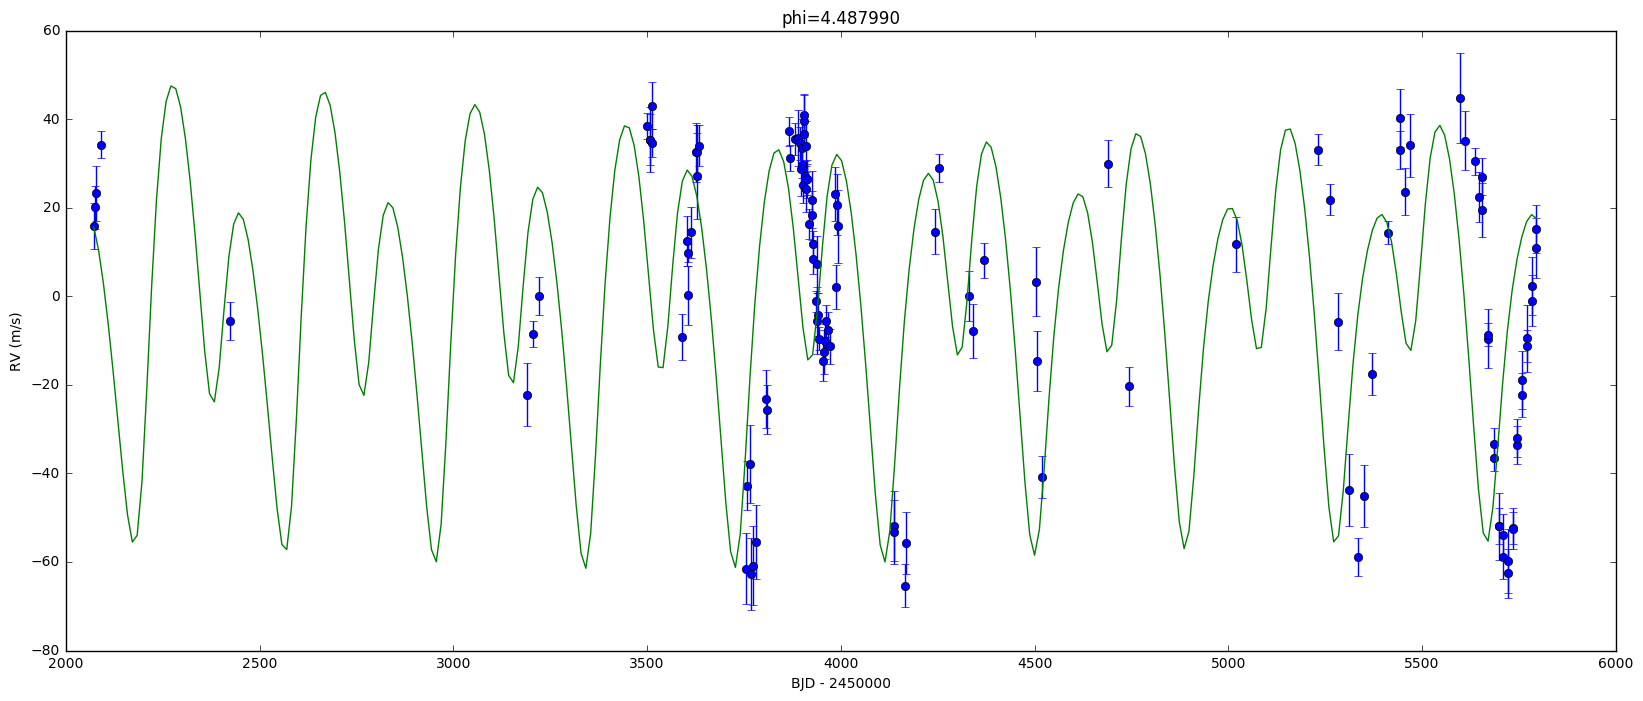

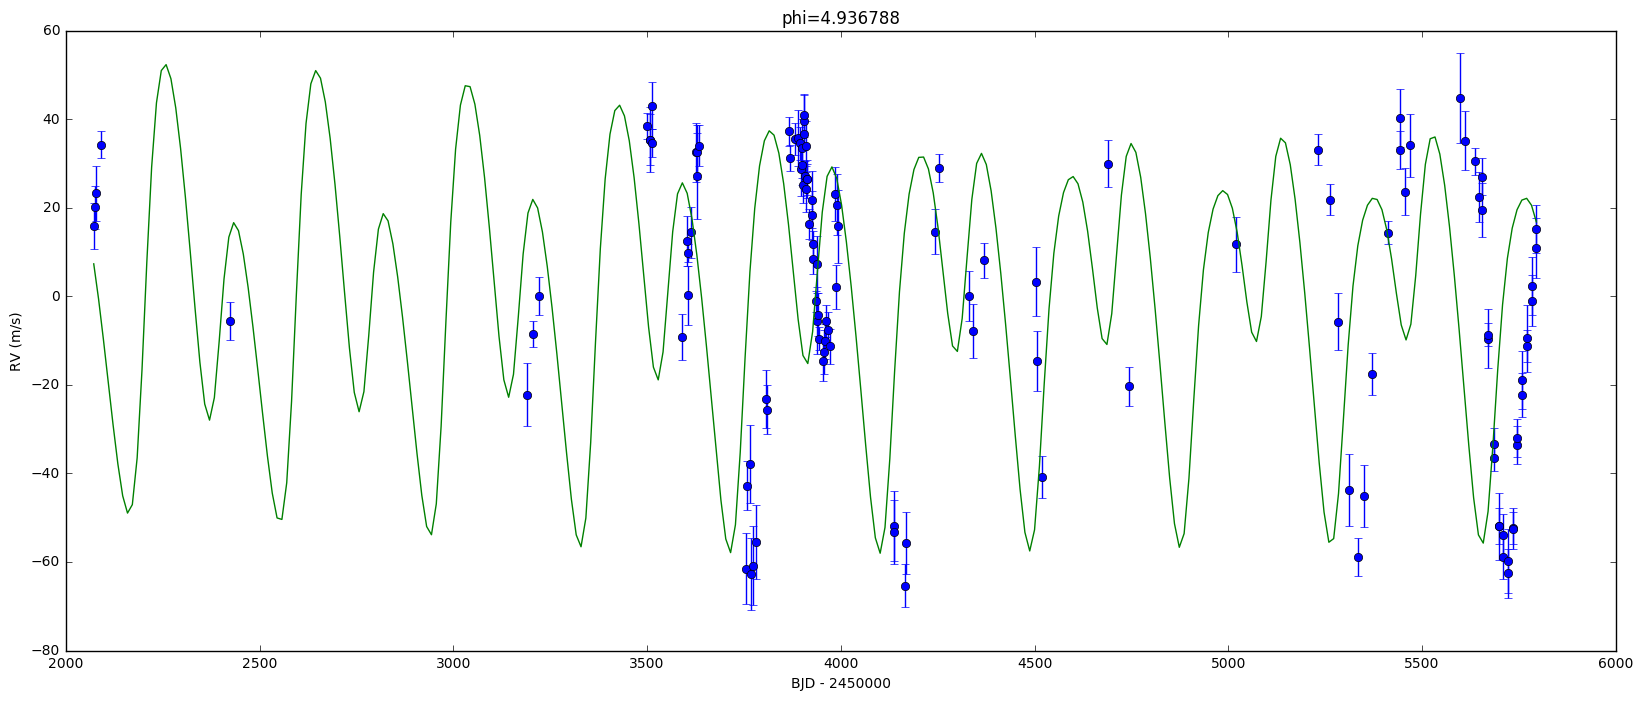

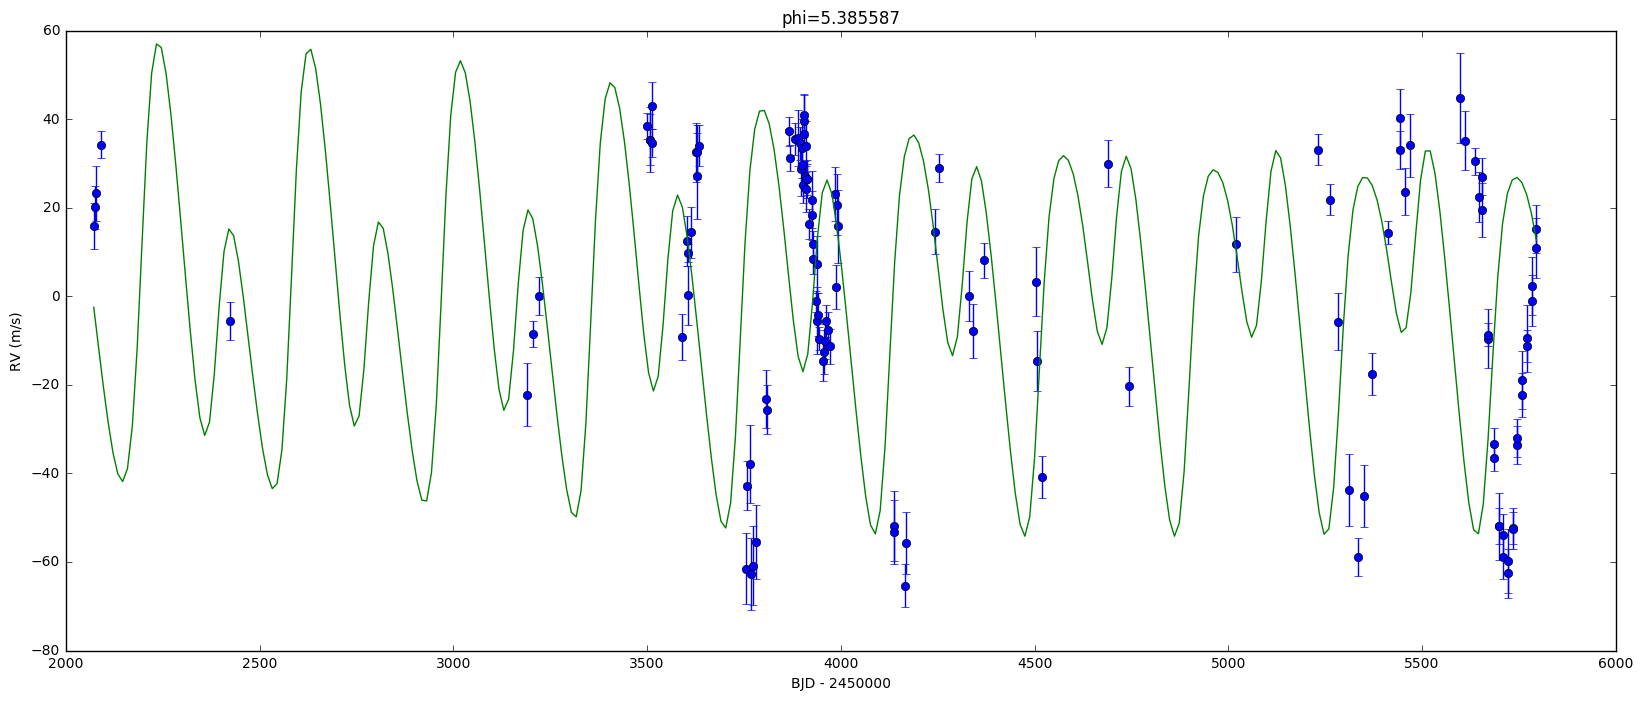

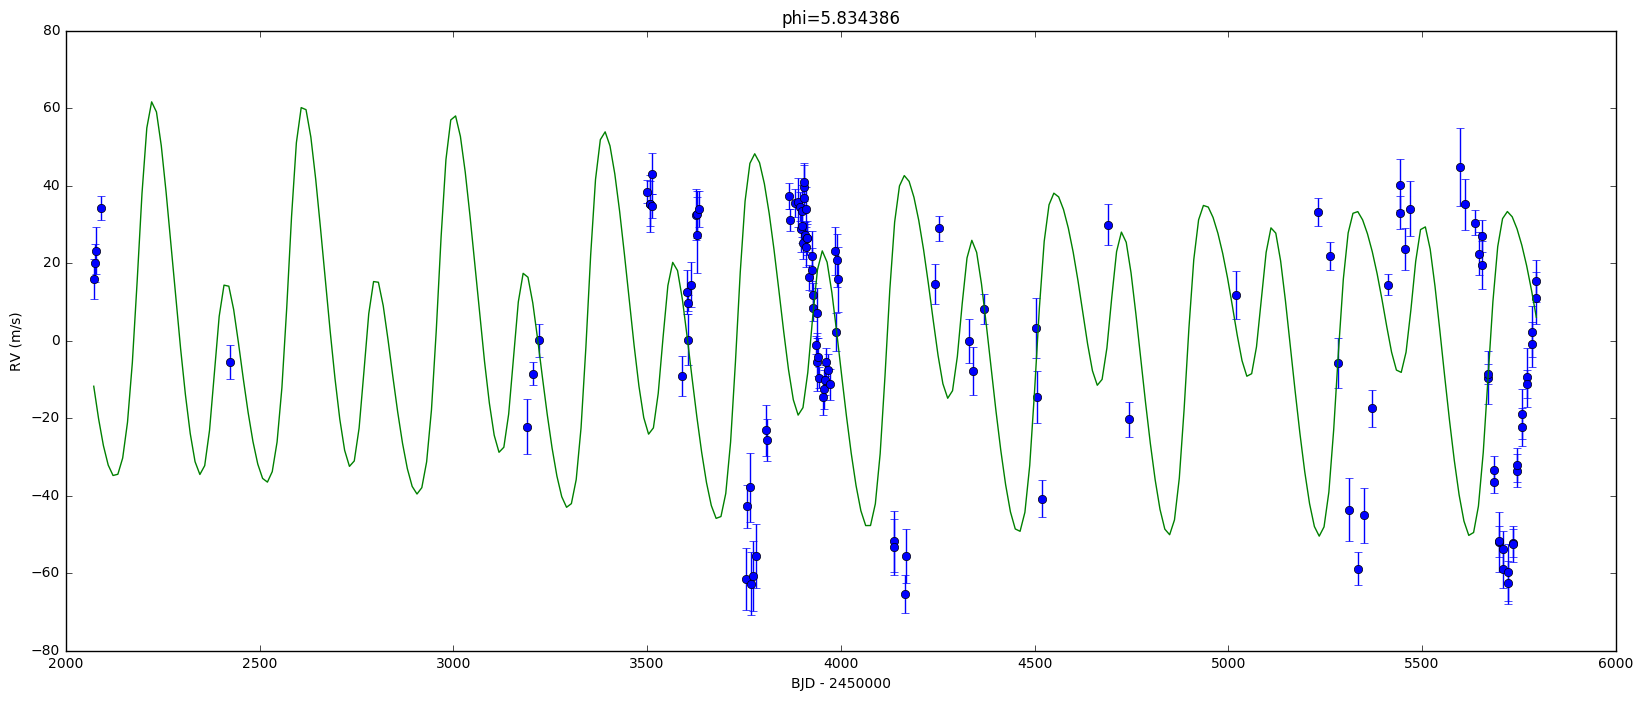

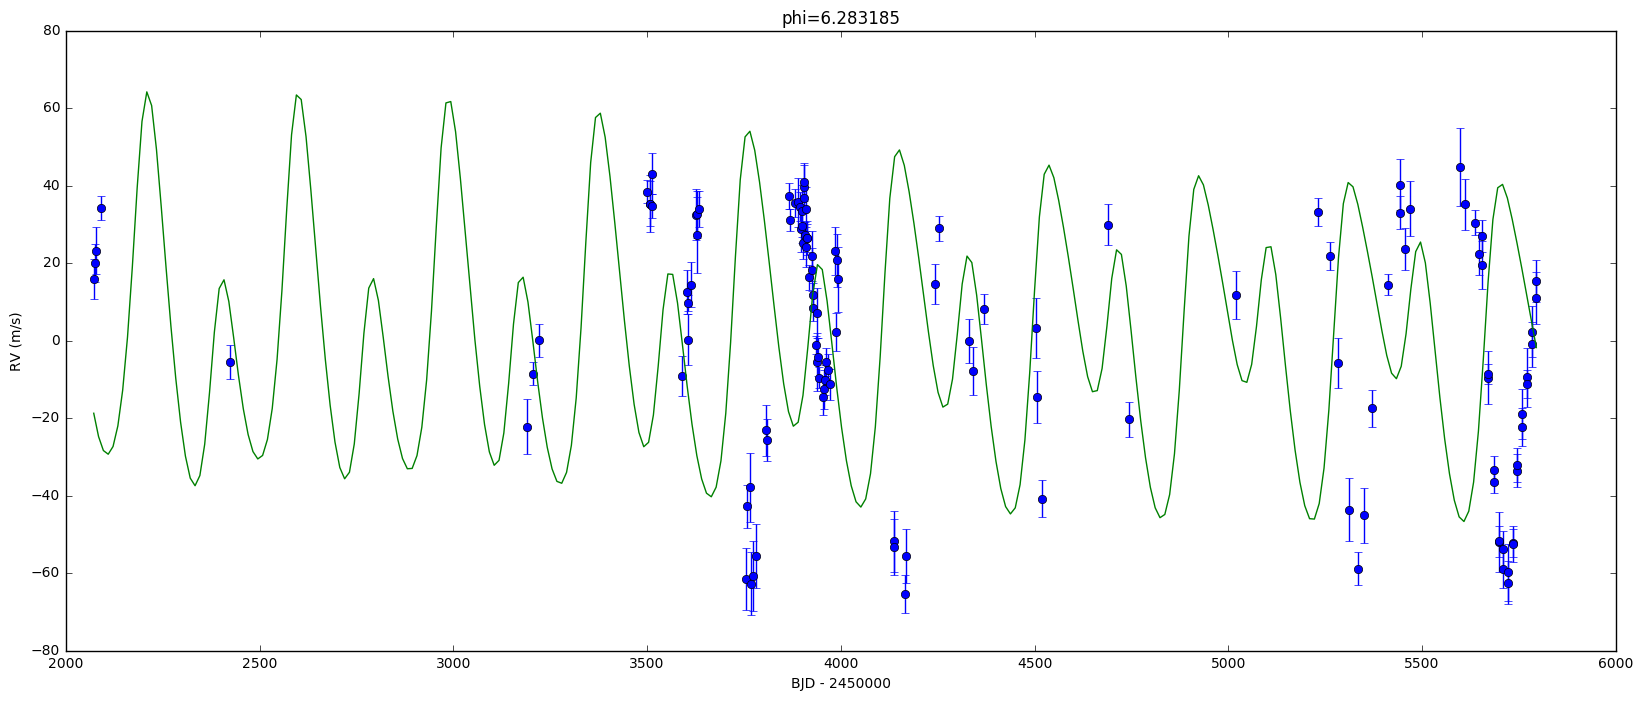

In [101]:
#need to add phi angle to fit_RV
phis = np.linspace(0,2*np.pi,15)
for phi in phis:    
    plt.figure(figsize=(20,8))
    plt.errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o')
    #plt.plot(data["BJD"],RV, 'o')
    plt.plot(tt,fit_RV(times,theta_robertson,phi))
    plt.xlabel("BJD - 2450000")
    plt.ylabel("RV (m/s)")
    plt.title('phi=%f'%phi)
    plt.savefig('robertson_fit_phi=%.2f.png'%phi)

## Emcee

In [24]:
def lnlike(theta_j, times, y, yerr2):
    theta, jitter2 = theta_j[:-1], theta_j[-1]
    model = fit_RV(times,theta)
    return -0.5*np.sum( (y - model)**2/(yerr2 + jitter2) + np.log(yerr2 + jitter2) )

def lnprior(theta_j):
    m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini,jitter2 = theta_j
    if 0.4<m1sini<2 and 0.4<m2sini<2 and 0.4<a1<0.75 and 0.8<a2<1.4 and 0<e1<1. and 0<e2<1. and 0<=w1<2*np.pi and 0<=w2<2*np.pi and 0.<=M1<=2*np.pi and 0.<=M2<=2*np.pi and 0.05<=sini<=1. and 0.<jitter2<50.:
        return 0   
    return -np.inf 

def lnprob(theta_j, times, y, yerr2):
    lnp = lnprior(theta_j)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta_j, times, y, yerr2)

In [6]:
#data
times = data["BJD"] - data["BJD"].iloc[0] #BJD (days)
m1sini,m2sini = 0.85,0.82                 #Jupiter masses, default 0.85,0.82
a1,a2 = 0.64,1.02                         #AU, default: 0.64, 1.02
e1,e2 = 0.3,0.16                          #default: 0.17,0.16
w1,w2 = 2.86,1.30                         #in radians, default: 143, 180
M1,M2 = 2.310,6.176                       #in degrees, default: 129, 233
sini = 1                                  #inclination angle
jitter2 = 2                               #stellar jitter term squared (m^2/s^2)

theta_ini = [m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini,jitter2]
ndim, nwalkers, n_it = len(theta_ini), 50, 5000

Run the MCMC. **Warning**. This could take a while.

In [28]:
pos = [theta_ini + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, data["RV"].values, (data["Unc"].values)**2));
sampler.run_mcmc(pos, n_it);
np.save("round2.npy",sampler.chain)

# Load and analyze data

In [48]:
#Corner plot
burnin = 500
#filename="emcee_chains/ewfit_nojitter_50walk_1500step"
#filename="emcee_chains/ewfit_jitter_nopool_nwalk50_nit1500"
filename="emcee_chains/ewfit_jitter_50walk_5000it"
samples = np.load(filename+".npy")[:, burnin:, :].reshape((-1, ndim))

In [36]:
labels=["$m_1sini$","$m_2sini$","$a_1$","$a_2$","$e_1$","$e_2$","$w_1$","$w_2$","$M_1$","$M_2$","$sini$","$jitter2$"]

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


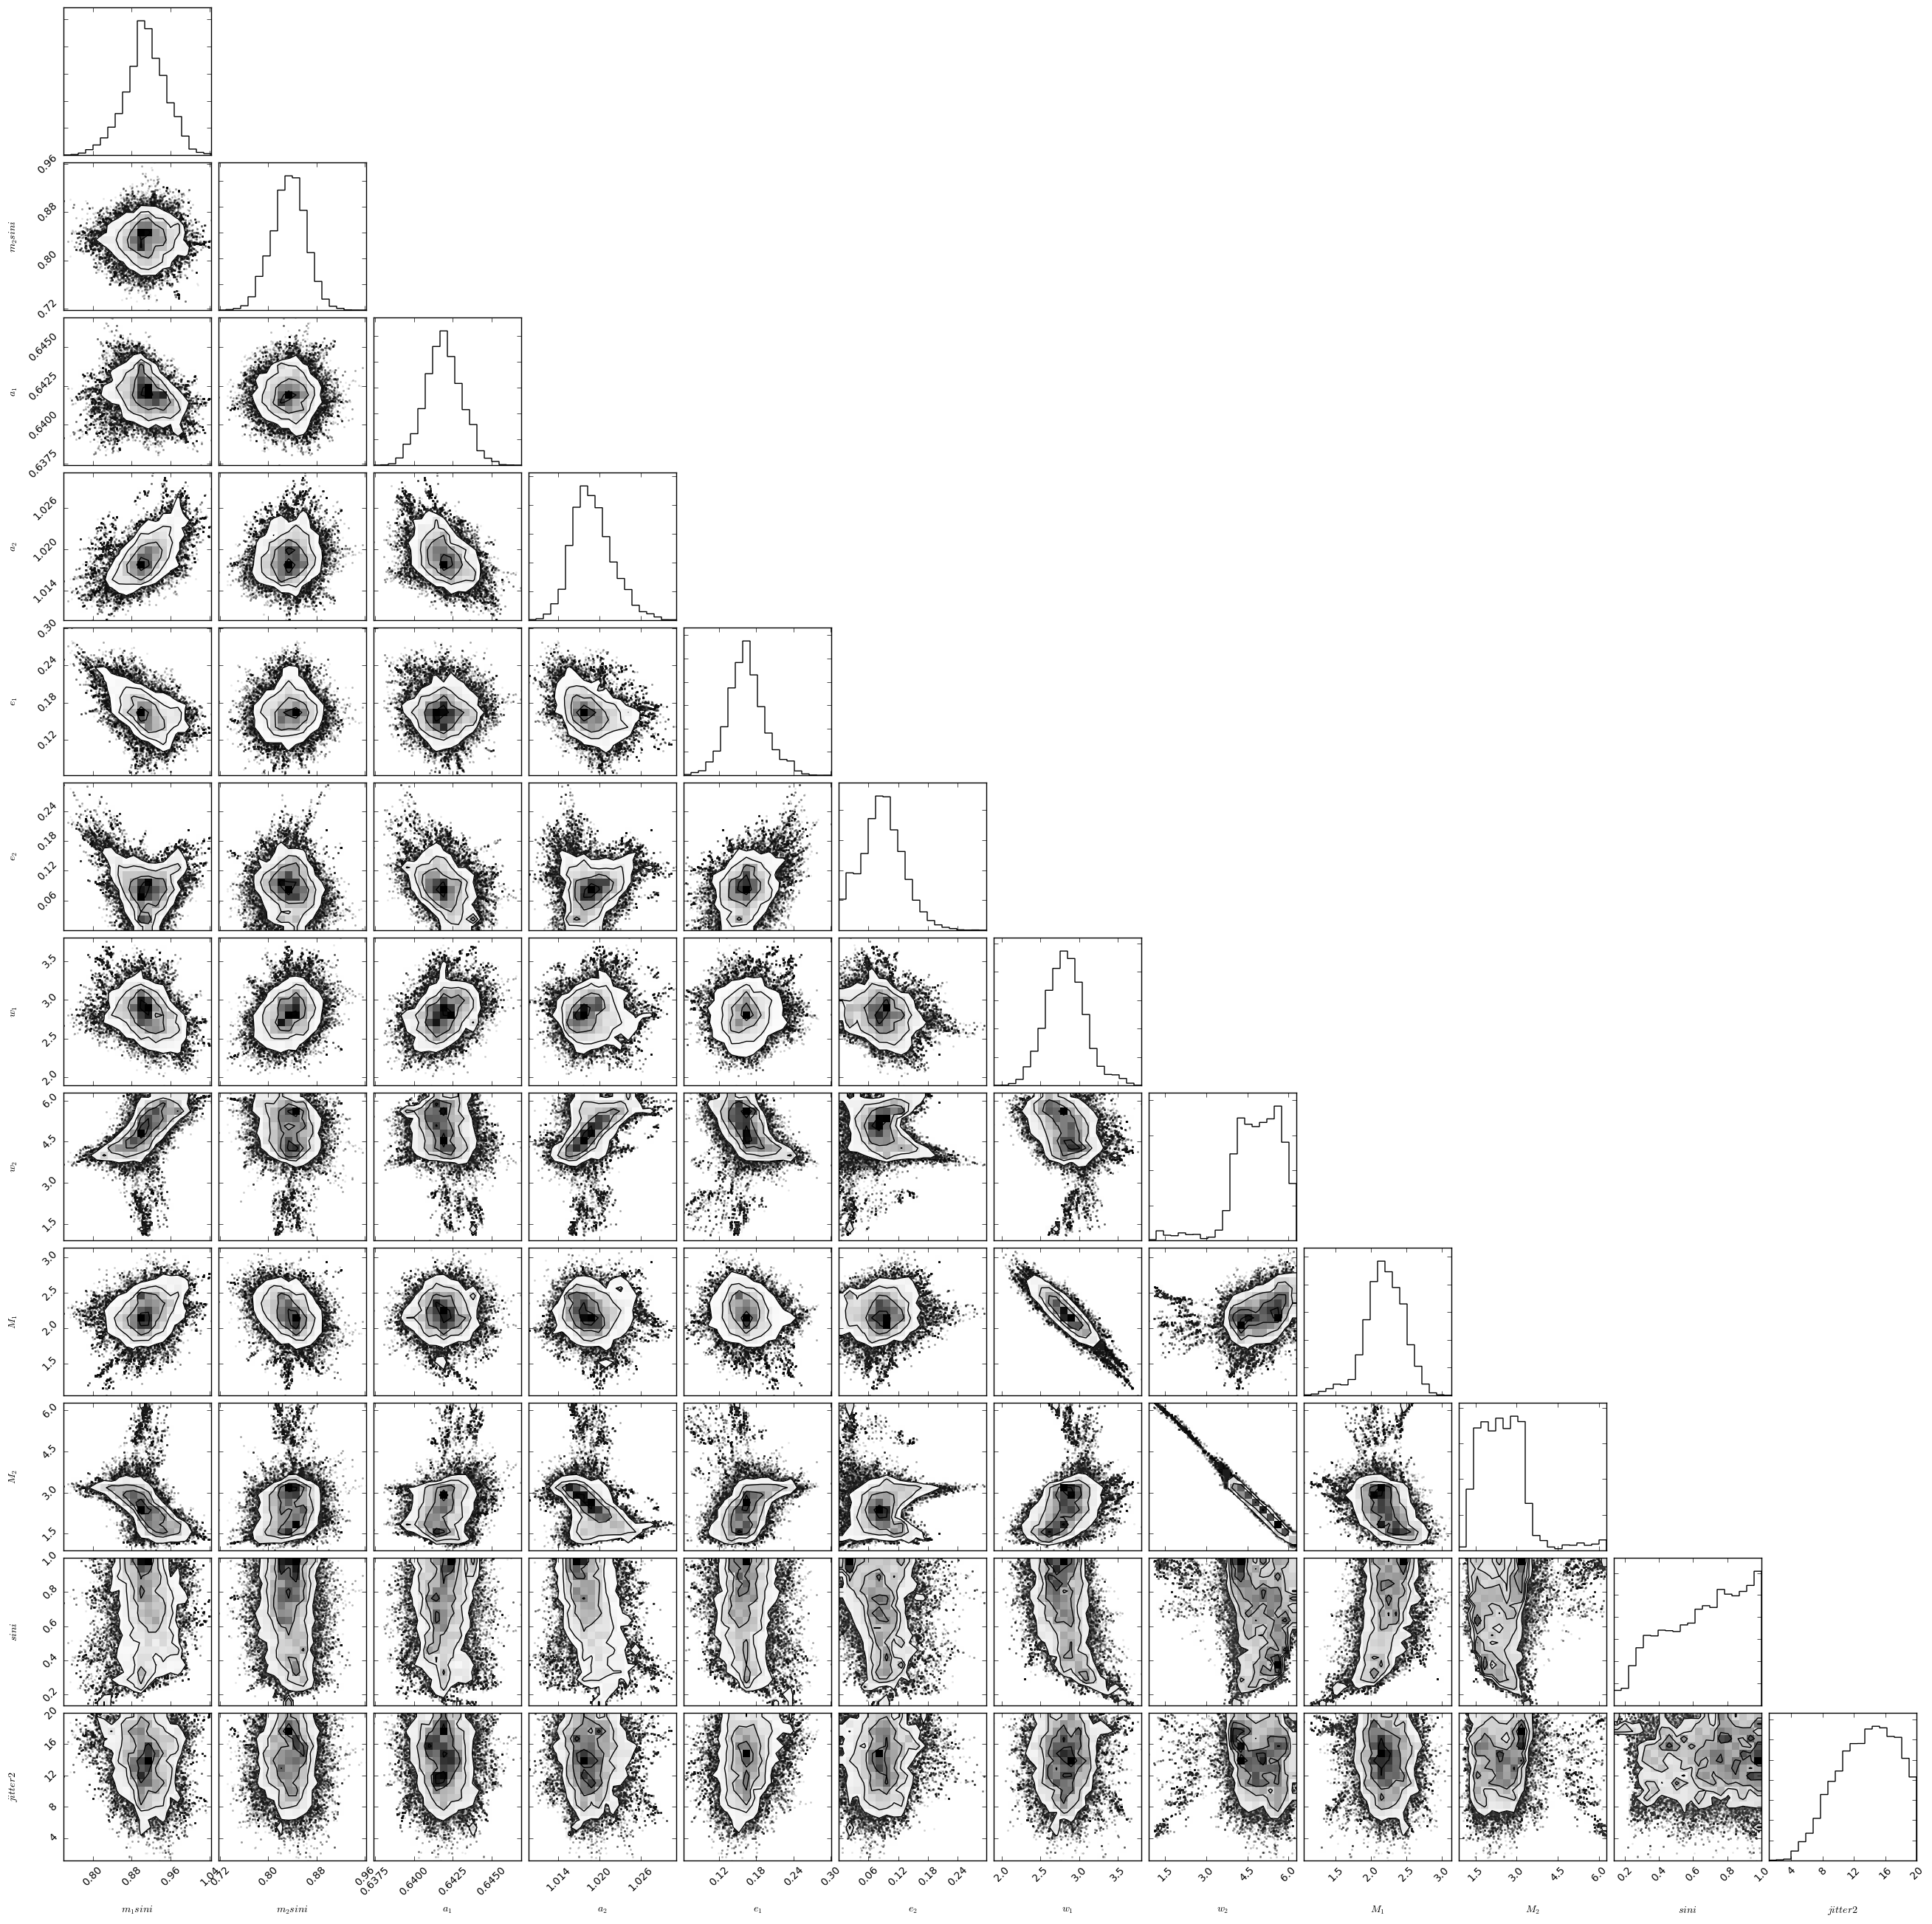

In [26]:
fig = corner.corner(samples, labels=labels)
fig.savefig(filename+"_corner.png")

In [68]:
#Better way to do this? This result could depend on the binning. 
labels=["m1sini","m2sini","a1","a2","e1","e2","w1","w2","M1","M2","sini","jit2"]
MAP, std = [], []
for i in range(ndim):
    n, bins, patches = plt.hist(samples[:,i], 101, normed=1, facecolor='green', alpha=0.75);
    MAP.append(bins[np.argmax(n)])
    std.append(np.std(samples[:,i]))
plt.close()
p=zip(labels,MAP,std)
print "parameter \t MAP \t\t std"
for i in range(ndim):
    print "%s \t\t %f \t %f"%(p[i][0],p[i][1],p[i][2])

parameter 	 MAP 		 std
m1sini 		 0.901900 	 0.038420
m2sini 		 0.830184 	 0.028964
a1 		 0.642038 	 0.001190
a2 		 1.017970 	 0.002785
e1 		 0.164208 	 0.029181
e2 		 0.076711 	 0.045277
w1 		 2.881468 	 0.247116
w2 		 5.566790 	 1.212777
M1 		 2.120047 	 0.266556
M2 		 3.100941 	 1.223403
sini 		 0.991438 	 0.221117
jit2 		 15.260446 	 4.324228


## Plot MAP

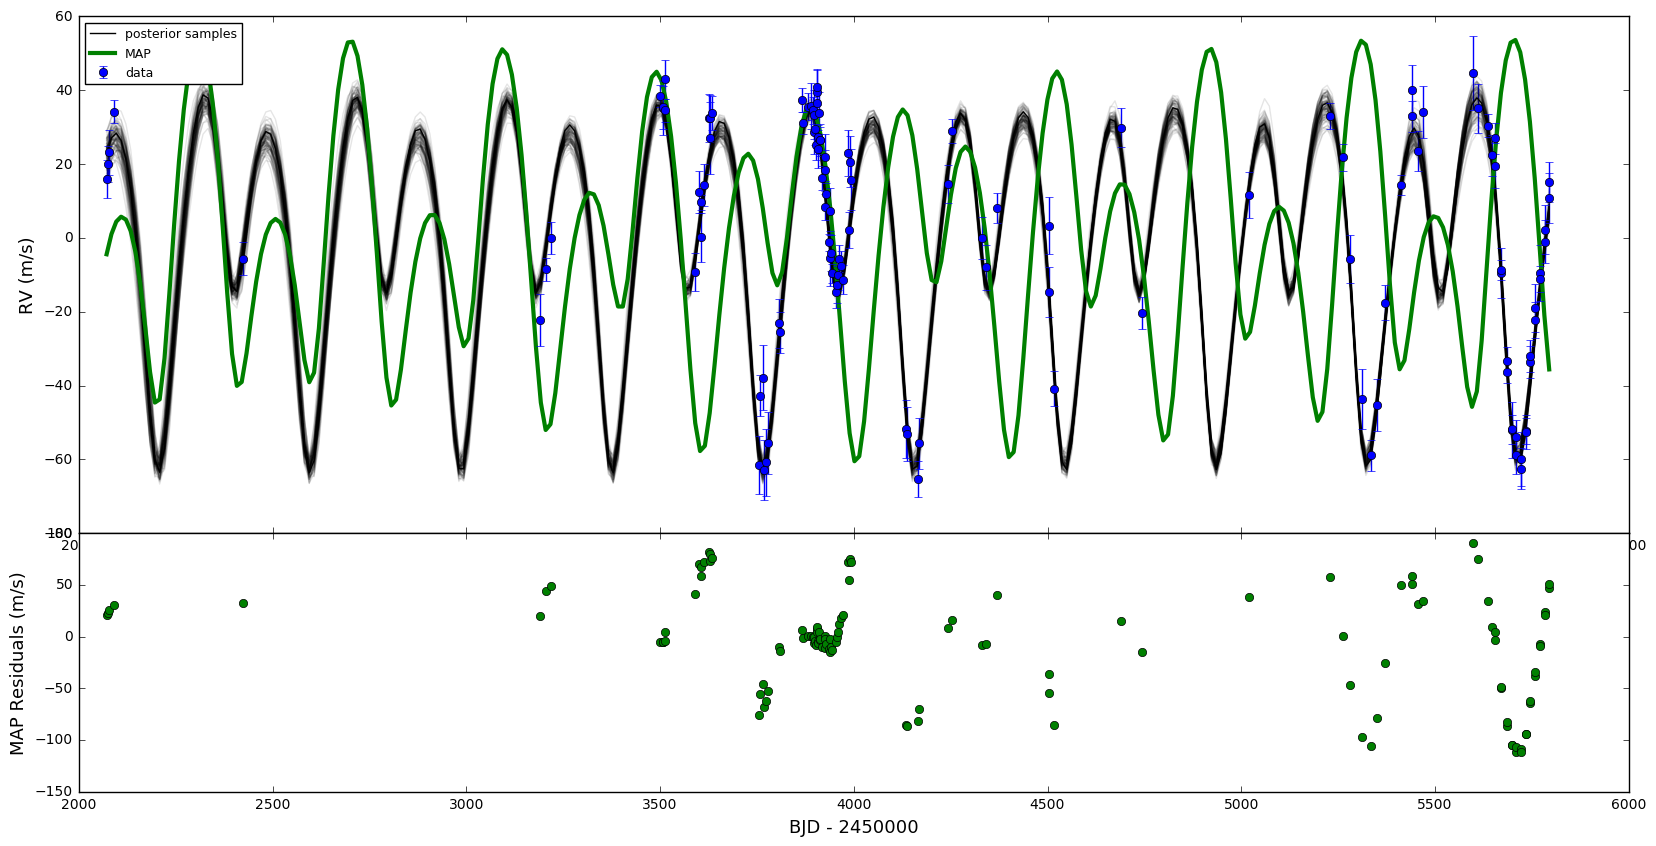

In [108]:
#plotting stuff
from matplotlib import gridspec
fontsize=13
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
axes = [plt.subplot(gs[0]),plt.subplot(gs[1])]
plt.subplots_adjust(hspace = 0)
axes[0].set_ylabel("RV (m/s)",fontsize=fontsize)
axes[1].set_ylabel("MAP Residuals (m/s)",fontsize=fontsize)
axes[1].set_xlabel("BJD - 2450000",fontsize=fontsize)

#samples from posterior
t0 = data["BJD"].iloc[0]
tt = np.linspace(t0,max(data["BJD"]),300)
for theta in samples[np.random.randint(len(samples), size=100)]:
    sampleRV = fit_RV(tt-t0,theta[:-1])
    axes[0].plot(tt,sampleRV,color="k", alpha=0.1)
axes[0].plot(tt,sampleRV,color="k", label='posterior samples')

#MAP
RV = fit_RV(tt-t0,MAP[:-1])
Residuals = data["RV"] - fit_RV(data["BJD"] - data["BJD"].iloc[0],MAP[:-1])
axes[0].plot(tt,RV, color='green',linewidth=3, label='MAP')
axes[0].errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o', color='blue', label='data')
axes[1].plot(data["BJD"],Residuals, 'o', color='green')

#save
axes[0].legend(loc="upper left",fontsize=9,numpoints=1)
plt.savefig(filename+"_MAP_RV2.png")

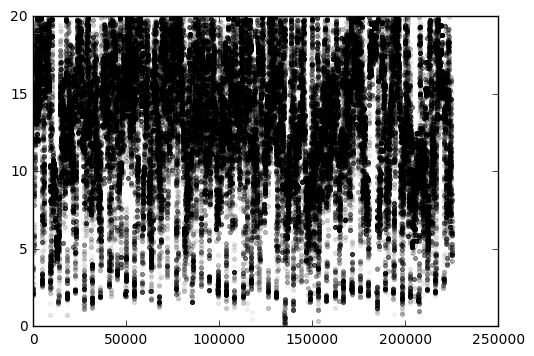

In [56]:
parameter = 11
plt.plot(samples[:,parameter], '.', alpha=0.05, color='black')

In [40]:
print "Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))